In [ ]:
conda install 

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [244]:
def calc_P_l(W,dt,X0=100):
    '''
    __THIS VERSION DOESN'T TRANSFORM X TO EXP, HENCE X CAN GO NEGATIVE__
    Inputs: W (matrix of Nsteps x Nl random numbers ~ N(0,1))
    Outputs: h(X) (payoff for each of the Nl paths)
    Calculate X for Nl paths over Nsteps 
    '''
    Nsteps,Nl=np.shape(W)
    X=X0*np.ones(Nl)
    for i in range(Nsteps):
        X+=r*X*dt + sig*X*W[i,:]
    return h(X)

In [237]:
eps=0.01
K=2
T=1
X0=100
N0=10000
r=0.05
sig=0.25
Lmax=int(-np.log(eps)/np.log(K)+1)

def f(x,r=0.05):
    return r*x

def g(x,sig=0.25):
    return sig*x

def h(x,E=100):
    x-=E
    x[x<0]=0
    return np.exp(-0.05*T)*x

In [258]:
def calc_P_l(W,dt,X0=100):
    '''
    Inputs: W (matrix of Nsteps x Nl random numbers ~ N(0,1))
    Outputs: h(X) (payoff for each of the Nl paths)
    Calculate X for Nl paths over Nsteps 
    '''
    Nsteps,Nl=np.shape(W)
    X=np.zeros(Nl)
    for i in range(Nsteps):
        X+=(r - 0.5*sig*sig)*dt + sig*W[i,:] #Develop as exponential to ensure underlying never goes negative
    X=X0*np.exp(X)
    return h(X)

def calc_DP_l(l,Nl,Nsteps):
    '''
    Inputs: l (current level), Nl (number of paths to simulate at level l), Nsteps (number of steps for path level l)
    Outputs: P_l-P_lm1 for Nl paths (payoff difference for each of the Nl paths with l and l-1 discretisation levels)
    '''
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    W=np.random.randn(Nsteps,Nl)*sqrt_dt
    P_l=calc_P_l(W,dt)
    
    Wnew=W[0::2,:]+W[1::2,:] # Can optimise maybe
    P_lm1=calc_P_l(Wnew,2*dt)
    
    return P_l-P_lm1

def calc_Yl(l):
    '''
    Inputs: l (current level)
    Outputs: Y_l (average payoff difference for Nl paths)
    '''
    Nsteps=K**l
    dt=T/Nsteps
    Nl=int(Lmax*dt/(eps**2))
    return np.sum(calc_DP_l(l,Nl,Nsteps))/Nl

In [259]:
Y=np.sum(calc_P_l(np.random.randn(T,N0),T))/N0
print(f'Y0 = {Y}')
Ys=[Y]
for l in range(1,Lmax+1):
    Ys+=[calc_Yl(l)]
    Y+=Ys[-1]
print(f'Y_L = {Y}')


Y0 = 12.444728400641662
Y_L = 12.444728400641656


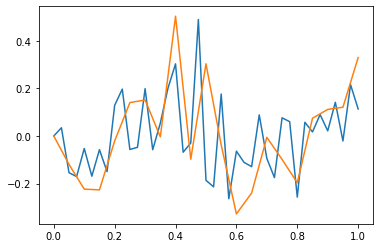

In [240]:
Nsteps=40
Nl=1
dt=T/Nsteps
steps1=np.arange(dt,T+dt,dt)
W=np.random.randn(Nsteps,Nl)*np.sqrt(dt)

Wnew=W[0::2,:]+W[1::2,:]
Nsteps,Nl=np.shape(Wnew)
dt=T/Nsteps
steps2=np.arange(dt,T+dt,dt)
steps1=[0]+list(steps1)
steps2=[0]+list(steps2)

W=[0]+list(W)
Wnew=[0]+list(Wnew)

plt.plot(steps1,W)
plt.plot(steps2,Wnew)

In [252]:
#Exact result according to BS formula
D1 =(r+sig**2/2)/sig
D2 = D1 - sig
100*norm.cdf(D1)-100*np.exp(-r)*norm.cdf(D2)

12.335998930368717